# Training Notebook for News Topic Classification

Model: **DistilBERT-base-uncased**

Dataset: **AG News** (120K articles, 4 topics)

Expected Time: **30-45 minutes on T4 GPU**

Expected Accuracy: **93-95%**

Actual Accuracy: **94.82%**

## Setup

In [1]:
# @title Mount to Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Create directory for this project in your Drive
import os
DRIVE_DIR = '/content/drive/MyDrive/NewsTopicClassification' # @param {"type":"string"}
os.makedirs(DRIVE_DIR, exist_ok=True)
print(f"✅ Google Drive mounted!")
print(f"📁 Project directory: {DRIVE_DIR}")

Mounted at /content/drive
✅ Google Drive mounted!
📁 Project directory: /content/drive/MyDrive/NewsTopicClassification


In [2]:
# @title Import packages & check GPU status

# @markdown


!pip install -q transformers datasets accelerate wandb evaluate scikit-learn

import torch
print(f"\n🎮 GPU Device: {torch.cuda.get_device_name(0)}")
print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"🔥 CUDA Available: {torch.cuda.is_available()}")

import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00

🎮 GPU Device: Tesla T4
💾 GPU Memory: 15.8 GB
🔥 CUDA Available: True


In [3]:
# @title Load dataset

dataset = load_dataset("ag_news")

print(f"✅ Dataset loaded!")
print(f"\n📊 Dataset structure:")
print(dataset)

print(f"\n🔢 Dataset sizes:")
print(f"  Training: {len(dataset['train']):,} articles")
print(f"  Test: {len(dataset['test']):,} articles")

# Define label names
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']
id2label = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
label2id = {'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}

print(f"\n🏷️  Topics: {label_names}")

# Show examples
print("\n📰 Sample articles:")
for i in range(3):
    example = dataset['train'][i]
    print(f"\n{i+1}. Topic: {label_names[example['label']]}")
    print(f"   Text: {example['text'][:100]}...")

# Check class distribution
from collections import Counter

train_labels = [example['label'] for example in dataset['train']]
label_counts = Counter(train_labels)

print(f"\n📊 Class distribution (training set):")
for label_id, count in sorted(label_counts.items()):
    percentage = (count / len(train_labels)) * 100
    print(f"  {label_names[label_id]}: {count:,} ({percentage:.1f}%)")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

✅ Dataset loaded!

📊 Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

🔢 Dataset sizes:
  Training: 120,000 articles
  Test: 7,600 articles

🏷️  Topics: ['World', 'Sports', 'Business', 'Sci/Tech']

📰 Sample articles:

1. Topic: Business
   Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\b...

2. Topic: Business
   Text: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,...

3. Topic: Business
   Text: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about th...

📊 Class distribution (training set):
  World: 30,000 (25.0%)
  Sports: 30,000 (25.0%)
  Business: 30,000 (25.0%)
  Sci/Tech: 30,000 (25.0%)


In [4]:
# @title Load DistilBERT tokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"✅ Tokenizer loaded: {model_name}")
print(f"📖 Vocabulary size: {tokenizer.vocab_size:,} tokens")

# Test tokenization
test_text = "Apple announces new iPhone with improved camera"
tokens = tokenizer.tokenize(test_text)
token_ids = tokenizer.encode(test_text)

print(f"\n🧪 Tokenization test:")
print(f"  Original: {test_text}")
print(f"  Tokens: {tokens}")
print(f"  Token IDs: {token_ids}")

# Tokenization function
def tokenize_function(examples):
    """Tokenize text with padding and truncation"""
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256  # News articles/titles are usually short
    )

print(f"\n⚙️  Tokenizing entire dataset...")

# Apply tokenization to entire dataset
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    num_proc=2,  # Parallel processing
    remove_columns=["text"]  # Remove original text to save memory
)

# Rename label column for trainer
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

print(f"✅ Tokenization complete!")
print(f"   Example tokenized sample:")
print(f"   Input IDs shape: {len(tokenized_datasets['train'][0]['input_ids'])}")
print(f"   Attention mask shape: {len(tokenized_datasets['train'][0]['attention_mask'])}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Tokenizer loaded: distilbert-base-uncased
📖 Vocabulary size: 30,522 tokens

🧪 Tokenization test:
  Original: Apple announces new iPhone with improved camera
  Tokens: ['apple', 'announces', 'new', 'iphone', 'with', 'improved', 'camera']
  Token IDs: [101, 6207, 17472, 2047, 18059, 2007, 5301, 4950, 102]

⚙️  Tokenizing entire dataset...


Map (num_proc=2):   0%|          | 0/120000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/7600 [00:00<?, ? examples/s]

✅ Tokenization complete!
   Example tokenized sample:
   Input IDs shape: 256
   Attention mask shape: 256


In [5]:
# @title Load pre-trained model with classification head

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4,  # 4 topic categories
    id2label=id2label,
    label2id=label2id
)

print(f"✅ Model loaded!")

# Model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / (1024**2):.1f} MB")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded!

📊 Model statistics:
  Total parameters: 66,956,548
  Trainable parameters: 66,956,548
  Model size: ~255.4 MB


In [6]:
# @title Setup evaluation metrics

# @markdown compute_metrics(predictions)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    """Compute accuracy, F1, precision, recall"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }

print("✅ Metrics defined: accuracy, F1, precision, recall")

✅ Metrics defined: accuracy, F1, precision, recall


In [7]:
# @title Training configurations

training_args = TrainingArguments(
    # Output directory - SAVE TO GOOGLE DRIVE!
    output_dir=f"{DRIVE_DIR}/training_checkpoints",

    # Training duration
    num_train_epochs=3,

    # Batch sizes (adjust if you get OOM errors)
    per_device_train_batch_size=32,   # For T4: 32 works well
    per_device_eval_batch_size=64,    # Evaluation can use larger batch

    # Optimizer settings
    learning_rate=2e-5,
    weight_decay=0.01,  # L2 regularization

    # Learning rate schedule
    warmup_steps=500,
    lr_scheduler_type="linear",

    # Evaluation strategy
    eval_strategy="steps",
    eval_steps=500,  # Evaluate every 500 steps
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,

    # Performance optimizations
    fp16=True,  # Mixed precision training (2x faster!)
    dataloader_num_workers=2,

    # Logging - SAVE TO GOOGLE DRIVE!
    logging_dir=f"{DRIVE_DIR}/logs",
    logging_steps=100,
    report_to="wandb",  # Comment out if not using wandb

    # Misc
    save_total_limit=2,  # Keep only 2 checkpoints (save space)
    seed=42,  # Reproducibility
    push_to_hub=False,  # Set True to upload to HuggingFace
)

print("✅ Training configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Train batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Mixed precision: {training_args.fp16}")

print("\n🏋️  Creating trainer...")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

✅ Training configuration:
  Epochs: 3
  Train batch size: 32
  Learning rate: 2e-05
  Mixed precision: True

🏋️  Creating trainer...


/tmp/ipython-input-3673140521.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
# @title Training and Evaluating

print("\n" + "="*70)
print("🚀 STARTING TRAINING")
print("="*70)
print("\n⏱️  Expected time: 30-45 minutes on T4 GPU")
print("📊 Watch progress in real-time at: https://wandb.ai/\n")

# Train!
train_result = trainer.train()

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)

# Print training summary
print("\n📊 Training Summary:")
print(f"  Total training time: {train_result.metrics['train_runtime']:.1f} seconds")
print(f"  Samples per second: {train_result.metrics['train_samples_per_second']:.1f}")
print(f"  Training loss: {train_result.metrics['train_loss']:.4f}")

print("\n📊 Evaluating on test set...")

# Evaluate
eval_results = trainer.evaluate()

print("\n" + "="*70)
print("📈 FINAL RESULTS")
print("="*70)
print(f"\n✨ Test Accuracy: {eval_results['eval_accuracy']:.4f} ({eval_results['eval_accuracy']*100:.2f}%)")
print(f"✨ F1 Score: {eval_results['eval_f1']:.4f}")
print(f"✨ Precision: {eval_results['eval_precision']:.4f}")
print(f"✨ Recall: {eval_results['eval_recall']:.4f}")


🚀 STARTING TRAINING

⏱️  Expected time: 30-45 minutes on T4 GPU
📊 Watch progress in real-time at: https://wandb.ai/



/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilsonz (wilsonz-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.296800,0.290665,0.905263,0.905300,0.905525,0.905263
1000,0.217300,0.222866,0.925395,0.925189,0.925403,0.925395
1500,0.248900,0.201094,0.932763,0.932794,0.932924,0.932763
2000,0.212800,0.200615,0.932368,0.932381,0.932487,0.932368
2500,0.176200,0.186931,0.936316,0.936352,0.936454,0.936316
3000,0.181500,0.190288,0.936053,0.936306,0.937118,0.936053
3500,0.175100,0.185890,0.939737,0.939684,0.939854,0.939737
4000,0.153700,0.180510,0.940921,0.940792,0.940786,0.940921
4500,0.135100,0.178498,0.945132,0.945152,0.945281,0.945132
5000,0.138900,0.174456,0.945263,0.945318,0.945519,0.945263



✅ TRAINING COMPLETE!

📊 Training Summary:
  Total training time: 2392.5 seconds
  Samples per second: 150.5
  Training loss: 0.1664

📊 Evaluating on test set...



📈 FINAL RESULTS

✨ Test Accuracy: 0.9482 (94.82%)
✨ F1 Score: 0.9482
✨ Precision: 0.9482
✨ Recall: 0.9482


## Model evaluation and summary

In [10]:
# @title Saving model

# Save final model to Google Drive
model_save_path = f"{DRIVE_DIR}/final_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"✅ Model saved to Google Drive: {model_save_path}")
print(f"\n📁 Your Google Drive now contains:")
print(f"  {DRIVE_DIR}/")
print(f"  ├── final_model/           ← Your trained model (USE THIS!)")
print(f"  ├── training_checkpoints/  ← Intermediate checkpoints")
print(f"  └── logs/                  ← Training logs")

# Also save to temporary location for quick testing
temp_save_path = "./final_model_temp"
trainer.save_model(temp_save_path)
tokenizer.save_pretrained(temp_save_path)
print(f"\n💡 Temporary copy also saved to: {temp_save_path}")
print(f"   (This will be deleted when session ends)")

print("\n📦 Creating downloadable zip file (optional backup)...")
!zip -r -q final_model.zip {model_save_path}

print("✅ Model zipped! You can download 'final_model.zip' from the file browser")
print("   (But it's already safe in your Google Drive!)")

✅ Model saved to Google Drive: /content/drive/MyDrive/NewsTopicClassification/final_model

📁 Your Google Drive now contains:
  /content/drive/MyDrive/NewsTopicClassification/
  ├── final_model/           ← Your trained model (USE THIS!)
  ├── training_checkpoints/  ← Intermediate checkpoints
  └── logs/                  ← Training logs

💡 Temporary copy also saved to: ./final_model_temp
   (This will be deleted when session ends)

📦 Creating downloadable zip file (optional backup)...
✅ Model zipped! You can download 'final_model.zip' from the file browser
   (But it's already safe in your Google Drive!)



📋 Classification Report:
              precision    recall  f1-score   support

       World     0.9614    0.9568    0.9591      1900
      Sports     0.9884    0.9889    0.9887      1900
    Business     0.9258    0.9126    0.9192      1900
    Sci/Tech     0.9173    0.9342    0.9257      1900

    accuracy                         0.9482      7600
   macro avg     0.9482    0.9482    0.9482      7600
weighted avg     0.9482    0.9482    0.9482      7600


🔢 Confusion Matrix:
[[1818    9   42   31]
 [   9 1879    7    5]
 [  37    5 1734  124]
 [  27    8   90 1775]]
✅ Confusion matrix saved as 'confusion_matrix.png'


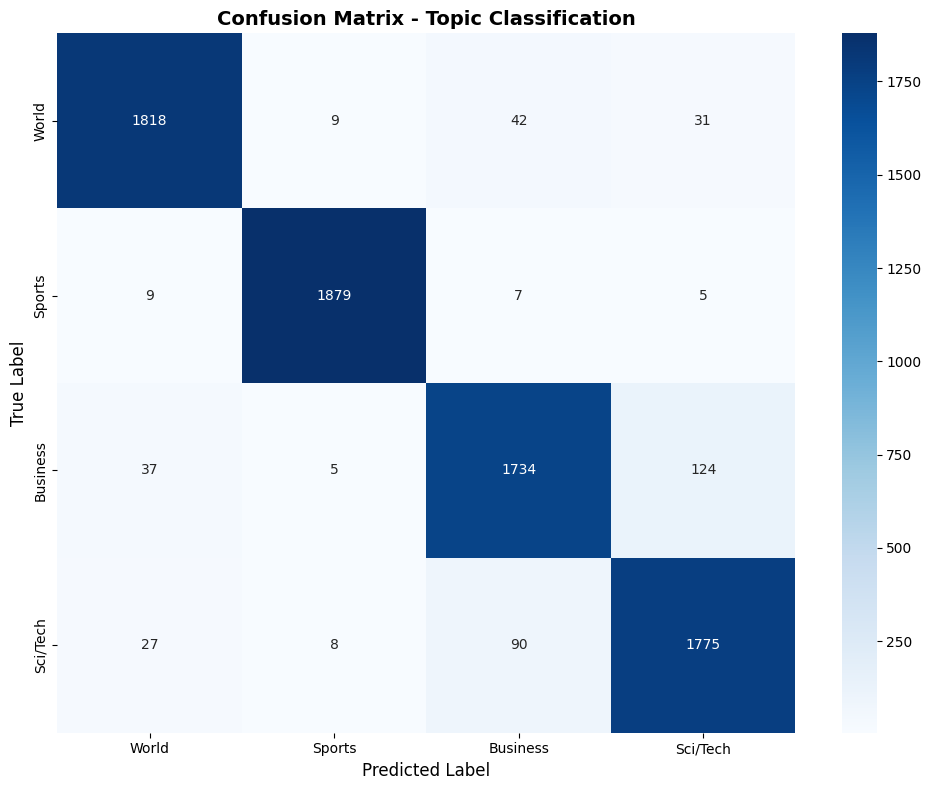


📊 Per-class Accuracy:
  World       :  1818/ 1900 = 95.68%
  Sports      :  1879/ 1900 = 98.89%
  Business    :  1734/ 1900 = 91.26%
  Sci/Tech    :  1775/ 1900 = 93.42%

❌ Sample Misclassifications:

  Text: IBM to hire even more new workers By the end of the year, the computing giant plans to have its biggest headcount since 1991....
  True: Sci/Tech | Predicted: Business

  Text: Some People Not Eligible to Get in on Google IPO Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street ...
  True: Sci/Tech | Predicted: Business

  Text: Rivals Try to Turn Tables on Charles Schwab By MICHAEL LIEDTKE     SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discount stock...
  True: Sci/Tech | Predicted: Business

  Text: Venezuela Prepares for Chavez Recall Vote Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world...
  True: World | Predicted: Business

  Text: Live: Olym

In [13]:
# @title Generate analysis

# Get predictions
predictions = trainer.predict(tokenized_datasets["test"])
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = tokenized_datasets["test"]["labels"]

# Classification report
print("\n📋 Classification Report:")
print("="*70)
report = classification_report(
    y_true,
    y_pred,
    target_names=label_names,
    digits=4
)
print(report)

# Confusion matrix
print("\n🔢 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('Confusion Matrix - Topic Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Confusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Per-class accuracy
print("\n📊 Per-class Accuracy:")
for i, label in enumerate(label_names):
    correct = cm[i, i]
    total = cm[i, :].sum()
    accuracy = correct / total * 100
    print(f"  {label:12s}: {correct:5d}/{total:5d} = {accuracy:5.2f}%")

# Find misclassified examples
print("\n❌ Sample Misclassifications:")
misclassified_indices = np.where(y_pred != y_true)[0][:5]  # First 5 errors

for idx in misclassified_indices:
    idx = int(idx)
    original_idx = int(idx)
    true_label = label_names[y_true[idx]]
    pred_label = label_names[y_pred[idx]]
    text = dataset['test'][original_idx]['text'][:150]

    print(f"\n  Text: {text}...")
    print(f"  True: {true_label} | Predicted: {pred_label}")

# Save visualizations to Drive
import shutil
shutil.copy('confusion_matrix.png', f"{DRIVE_DIR}/confusion_matrix.png")
print(f"\n✅ Confusion matrix also saved to Google Drive")

In [14]:
# @title Testing on custom examples

def predict_topic(text):
    """Predict topic for custom text"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    predicted_class = torch.argmax(predictions, dim=-1).item()
    confidence = predictions[0][predicted_class].item()

    return {
        'topic': label_names[predicted_class],
        'confidence': confidence,
        'all_scores': {label_names[i]: predictions[0][i].item() for i in range(4)}
    }

# Test examples
test_examples = [
    "Apple announces new iPhone 15 with improved camera and battery life",
    "Lakers defeat Warriors 120-110 in overtime thriller",
    "Stock market reaches all-time high as tech stocks surge",
    "Scientists discover new planet in habitable zone",
    "Tesla reports record quarterly earnings, stock jumps 15%",
    "World leaders meet for climate summit in Paris"
]

print("\n" + "="*70)
print("🎯 PREDICTIONS ON CUSTOM EXAMPLES")
print("="*70)

for i, text in enumerate(test_examples, 1):
    result = predict_topic(text)
    print(f"\n{i}. {text}")
    print(f"   → {result['topic']} ({result['confidence']:.2%} confidence)")
    print(f"   Scores: ", end="")
    for topic, score in result['all_scores'].items():
        print(f"{topic}: {score:.3f}  ", end="")
    print()


🎯 PREDICTIONS ON CUSTOM EXAMPLES

1. Apple announces new iPhone 15 with improved camera and battery life
   → Sci/Tech (98.47% confidence)
   Scores: World: 0.006  Sports: 0.000  Business: 0.009  Sci/Tech: 0.985  

2. Lakers defeat Warriors 120-110 in overtime thriller
   → Sports (94.96% confidence)
   Scores: World: 0.050  Sports: 0.950  Business: 0.000  Sci/Tech: 0.000  

3. Stock market reaches all-time high as tech stocks surge
   → Business (99.71% confidence)
   Scores: World: 0.002  Sports: 0.000  Business: 0.997  Sci/Tech: 0.001  

4. Scientists discover new planet in habitable zone
   → Sci/Tech (90.99% confidence)
   Scores: World: 0.087  Sports: 0.001  Business: 0.002  Sci/Tech: 0.910  

5. Tesla reports record quarterly earnings, stock jumps 15%
   → Business (98.28% confidence)
   Scores: World: 0.009  Sports: 0.000  Business: 0.983  Sci/Tech: 0.008  

6. World leaders meet for climate summit in Paris
   → World (55.05% confidence)
   Scores: World: 0.551  Sports: 0.000 

In [18]:
# @title Create results summary
summary = {
    'model': model_name,
    'dataset': 'AG News',
    'train_samples': len(dataset['train']),
    'test_samples': len(dataset['test']),
    'epochs': training_args.num_train_epochs,
    'batch_size': training_args.per_device_train_batch_size,
    'learning_rate': training_args.learning_rate,
    'accuracy': eval_results['eval_accuracy'],
    'f1_score': eval_results['eval_f1'],
    'precision': eval_results['eval_precision'],
    'recall': eval_results['eval_recall'],
    'training_time_seconds': train_result.metrics['train_runtime'],
}

# Save as JSON to Google Drive
import json
with open(f'{DRIVE_DIR}/training_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n📄 Results summary saved to Google Drive: training_summary.json")

# Save as markdown report to Google Drive
report_md = f"""# Topic Classification Model - Training Report

## Model Information
- **Model**: {summary['model']}
- **Dataset**: {summary['dataset']}
- **Training Samples**: {summary['train_samples']:,}
- **Test Samples**: {summary['test_samples']:,}

## Training Configuration
- **Epochs**: {summary['epochs']}
- **Batch Size**: {summary['batch_size']}
- **Learning Rate**: {summary['learning_rate']}
- **Training Time**: {summary['training_time_seconds']:.1f} seconds ({summary['training_time_seconds']/60:.1f} minutes)

## Results
- **Accuracy**: {summary['accuracy']:.4f} ({summary['accuracy']*100:.2f}%)
- **F1 Score**: {summary['f1_score']:.4f}
- **Precision**: {summary['precision']:.4f}
- **Recall**: {summary['recall']:.4f}

## Per-Class Performance
{report}

## Files Saved to Google Drive
- `{DRIVE_DIR}/final_model/` - Trained model (use this!)
- `{DRIVE_DIR}/training_checkpoints/` - Training checkpoints
- `{DRIVE_DIR}/logs/` - Training logs
- `{DRIVE_DIR}/confusion_matrix.png` - Visualization
- `{DRIVE_DIR}/training_summary.json` - Metrics
- `{DRIVE_DIR}/training_report.md` - This report

## Next Steps
1. ✅ Model trained and evaluated
2. ✅ Saved to Google Drive (permanent!)
3. 🔄 Integrate into news recommender pipeline
4. 🚀 Deploy for production use
"""

with open(f'{DRIVE_DIR}/training_report.md', 'w') as f:
    f.write(report_md)

print("✅ Detailed report saved to Google Drive: training_report.md")

print("\n" + "="*70)
print("🎉 ALL DONE!")
print("="*70)

print(f"""
📊 Final Summary:
  ✨ Model: DistilBERT-base-uncased
  ✨ Accuracy: {eval_results['eval_accuracy']*100:.2f}%
  ✨ F1 Score: {eval_results['eval_f1']:.4f}
  ✨ Training Time: {train_result.metrics['train_runtime']/60:.1f} minutes

📁 All Files Saved to Google Drive:
  ✅ {DRIVE_DIR}/final_model/
  ✅ {DRIVE_DIR}/training_checkpoints/
  ✅ {DRIVE_DIR}/logs/
  ✅ {DRIVE_DIR}/confusion_matrix.png
  ✅ {DRIVE_DIR}/training_summary.json
  ✅ {DRIVE_DIR}/training_report.md

💡 How to Access Your Files:
  1. Open Google Drive (drive.google.com)
  2. Navigate to: My Drive > news_recommender
  3. Download the 'final_model' folder
  4. Use it in your project!
""")

# Close wandb
# wandb.finish()


📄 Results summary saved to Google Drive: training_summary.json
✅ Detailed report saved to Google Drive: training_report.md

🎉 ALL DONE!

📊 Final Summary:
  ✨ Model: DistilBERT-base-uncased
  ✨ Accuracy: 94.82%
  ✨ F1 Score: 0.9482
  ✨ Training Time: 39.9 minutes
  
📁 All Files Saved to Google Drive:
  ✅ /content/drive/MyDrive/NewsTopicClassification/final_model/
  ✅ /content/drive/MyDrive/NewsTopicClassification/training_checkpoints/
  ✅ /content/drive/MyDrive/NewsTopicClassification/logs/
  ✅ /content/drive/MyDrive/NewsTopicClassification/confusion_matrix.png
  ✅ /content/drive/MyDrive/NewsTopicClassification/training_summary.json
  ✅ /content/drive/MyDrive/NewsTopicClassification/training_report.md
  
💡 How to Access Your Files:
  1. Open Google Drive (drive.google.com)
  2. Navigate to: My Drive > news_recommender
  3. Download the 'final_model' folder
  4. Use it in your project!



## Inference

In [19]:
# ============================================================================
# QUICK REFERENCE: HOW TO LOAD THIS MODEL LATER
# ============================================================================
"""
# To load this model in your FastAPI backend:

from transformers import pipeline

# Load from saved directory
classifier = pipeline(
    "text-classification",
    model="./final_model",
    device=0  # Use GPU if available, -1 for CPU
)

# Classify an article
result = classifier("Apple announces new iPhone")[0]
print(result)
# Output: {'label': 'Sci/Tech', 'score': 0.96}

# Batch classification (faster!)
articles = [
    "Lakers win championship",
    "Stock market hits record high",
    "New AI breakthrough announced"
]
results = classifier(articles)
for article, result in zip(articles, results):
    print(f"{article[:30]}... → {result['label']} ({result['score']:.2f})")
"""

'\n# To load this model in your FastAPI backend:\n\nfrom transformers import pipeline\n\n# Load from saved directory\nclassifier = pipeline(\n    "text-classification",\n    model="./final_model",\n    device=0  # Use GPU if available, -1 for CPU\n)\n\n# Classify an article\nresult = classifier("Apple announces new iPhone")[0]\nprint(result)\n# Output: {\'label\': \'Sci/Tech\', \'score\': 0.96}\n\n# Batch classification (faster!)\narticles = [\n    "Lakers win championship",\n    "Stock market hits record high",\n    "New AI breakthrough announced"\n]\nresults = classifier(articles)\nfor article, result in zip(articles, results):\n    print(f"{article[:30]}... → {result[\'label\']} ({result[\'score\']:.2f})")\n'